In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
from scipy import sparse

In [2]:
data = pd.read_csv('healthcare_dataset.csv', delimiter=',', encoding='ISO-8859-1')
data = data.drop(columns=['Date of Admission','Name','Discharge Date','Doctor'])
data.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


In [3]:
columns_to_encode = ['Gender', 'Blood Type', 'Medical Condition', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
unique_values = {}
for col in columns_to_encode:
    labels, unique = pd.factorize(data[col])
    data[f'{col}_c'] = labels
    unique_values[col] = unique

print(data)

for col, unique in unique_values.items():
    print(f'{col}: {list(unique)}')

       Age  Gender Blood Type Medical Condition                      Hospital  \
0       30    Male         B-            Cancer               Sons and Miller   
1       62    Male         A+           Obesity                       Kim Inc   
2       76  Female         A-           Obesity                      Cook PLC   
3       28  Female         O+          Diabetes    Hernandez Rogers and Vang,   
4       43  Female        AB+            Cancer                   White-White   
...    ...     ...        ...               ...                           ...   
55495   42  Female         O+            Asthma                Jones-Thompson   
55496   61  Female        AB-           Obesity                  Tucker-Moyer   
55497   38  Female         B+      Hypertension  and Mahoney Johnson Vasquez,   
55498   43    Male         O-         Arthritis      Jackson Todd and Castro,   
55499   53  Female         O+         Arthritis                Henry Sons and   

      Insurance Provider  B

<Axes: >

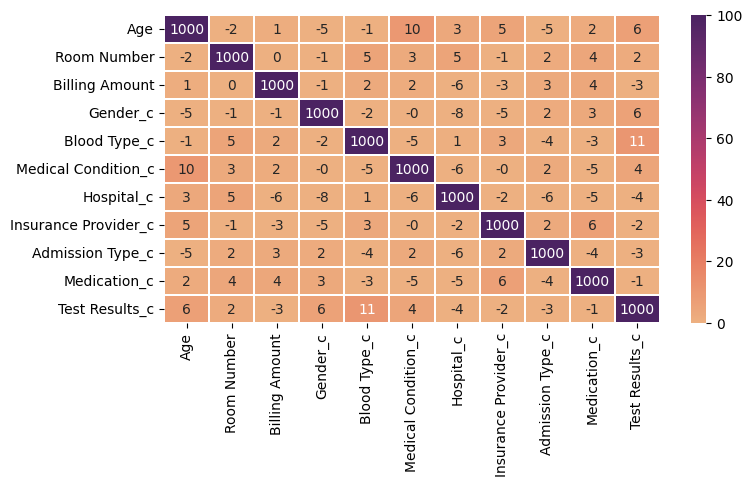

In [4]:
columns = ['Gender_c','Blood Type_c','Medical Condition_c','Hospital_c','Insurance Provider_c','Admission Type_c','Medication_c', 'Test Results_c']


scaler = MinMaxScaler()
columns_scalled = scaler.fit_transform(data[columns])

age_RN_data = data[['Age', 'Room Number']]

billing_data = data[['Billing Amount']]
scaled_data = MinMaxScaler().fit_transform(billing_data)

age_RN_sparse = sparse.csr_matrix(age_RN_data.values)
scaled_sparse = sparse.csr_matrix(scaled_data)
columns_scalled = sparse.csr_matrix(columns_scalled)

prepped_sparse = sparse.hstack([columns_scalled, scaled_sparse, age_RN_data])

prepped_data = pd.DataFrame.sparse.from_spmatrix(prepped_sparse, columns=['Age','Room Number','Billing Amount'] + columns)


corr = prepped_data.corr(method='pearson')*1000
plt.figure(figsize=(8,4))
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=100,
            fmt=".0f", cmap=sns.color_palette("flare", as_cmap=True))

In [5]:
columns_features = ['Gender_c','Blood Type_c','Medical Condition_c','Hospital_c','Insurance Provider_c','Admission Type_c','Medication_c', 'Test Results_c'] 
features = prepped_data[columns_features]
target = prepped_data['Test Results_c']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) 
reg = LogisticRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
y_pred

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([420., 486., 286., ..., 420., 174., 486.])

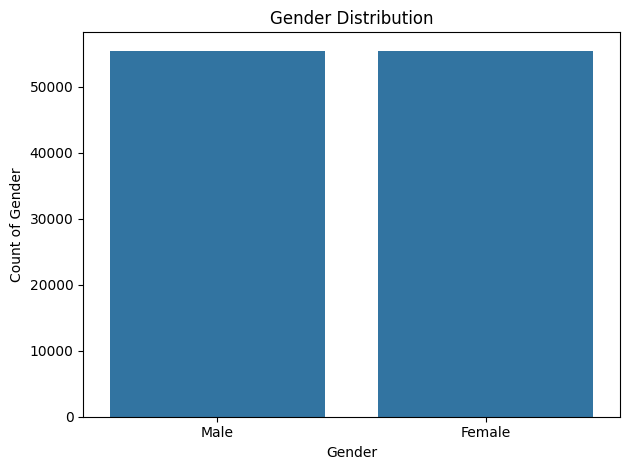

In [6]:
sns.barplot(x=data['Gender'], y=data['Gender'].count())
plt.title('Gender Distribution')
plt.ylabel('Count of Gender')
plt.tight_layout()
plt.show()

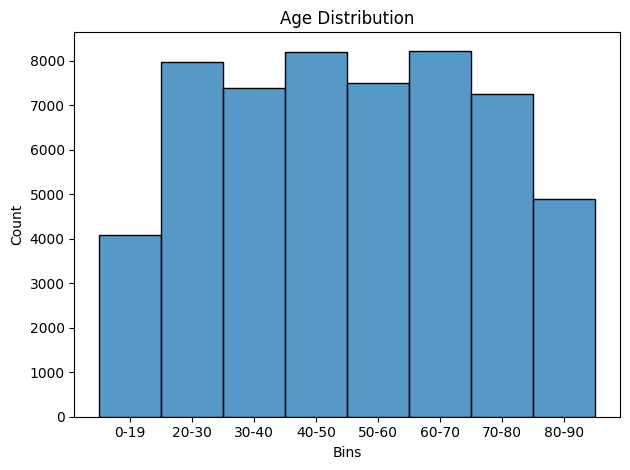

In [7]:
labels = ['0-19', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
data['Age_Binned'] = pd.cut(data['Age'], bins=8, labels=labels)

sns.histplot(x=data['Age_Binned'], bins=8)
plt.title('Age Distribution')
plt.ylabel('Count')
plt.xlabel('Bins')
plt.tight_layout()
plt.show()

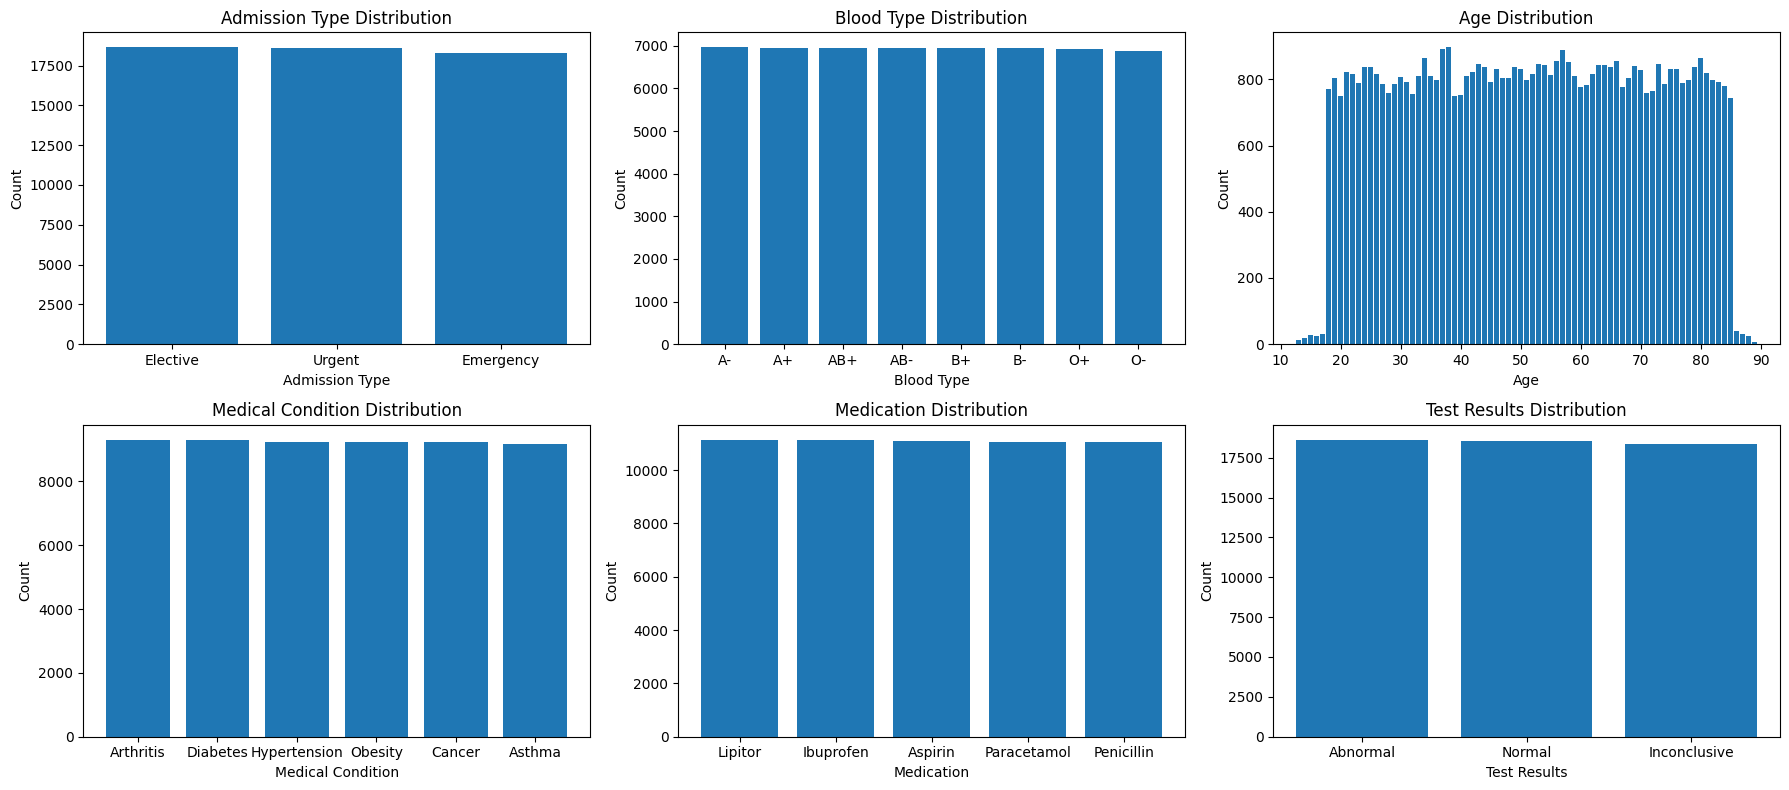

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

variables = ['Admission Type', 'Blood Type', 'Age', 'Medical Condition', 'Medication', 'Test Results']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel(var)

plt.tight_layout()
plt.show()

In [9]:
from scipy import sparse

# Encoding categorical columns with sparse output
encoder = OneHotEncoder()

encoded_sparse = encoder.fit_transform(data[columns_to_encode])

# Extracting and preparing other columns
age_RN_data = data[['Age', 'Room Number']]

# Scaling billing data
billing_data = data[['Billing Amount']]
scaled_data = StandardScaler().fit_transform(billing_data)

# Creating sparse matrices for age_RN_data and scaled_data
age_RN_sparse = sparse.csr_matrix(age_RN_data.values)
scaled_sparse = sparse.csr_matrix(scaled_data)

# Concatenating all data
prepped_sparse = sparse.hstack([age_RN_sparse, scaled_sparse, encoded_sparse])

# Converting back to DataFrame for further usage if needed
prepped_data = pd.DataFrame.sparse.from_spmatrix(prepped_sparse, columns=['Age', 'Room Number', 'Billing Amount'] + list(encoder.get_feature_names_out(columns_to_encode)))

In [10]:
prepped_data

,Age,Room Number,Billing Amount,Gender_Female,Gender_Male,Blood Type_A+,Blood Type_A-,Blood Type_AB+,Blood Type_AB-,Blood Type_B+,...,Admission Type_Emergency,Admission Type_Urgent,Medication_Aspirin,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
0,30.0,328.0,-0.470261,0,1.0,0,0,0,0,0,...,0,1.0,0,0,0,1.0,0,0,0,1.0
1,62.0,265.0,0.57025,0,1.0,1.0,0,0,0,0,...,1.0,0,0,1.0,0,0,0,0,1.0,0
2,76.0,205.0,0.16999,1.0,0,0,1.0,0,0,0,...,1.0,0,1.0,0,0,0,0,0,0,1.0
3,28.0,450.0,0.870465,1.0,0,0,0,0,0,0,...,0,0,0,1.0,0,0,0,1.0,0,0
4,43.0,458.0,-0.795211,1.0,0,0,0,1.0,0,0,...,0,1.0,0,0,0,0,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,42.0,417.0,-1.610589,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,1.0,0,0
55496,61.0,316.0,0.416462,1.0,0,0,0,0,1.0,0,...,0,0,1.0,0,0,0,0,0,0,1.0
55497,38.0,347.0,0.146464,1.0,0,0,0,0,0,1.0,...,0,1.0,0,1.0,0,0,0,1.0,0,0
55498,43.0,321.0,0.486357,0,1.0,0,0,0,0,0,...,0,0,0,1.0,0,0,0,1.0,0,0
